In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype

# Cargamos los datasets
df = pd.read_csv("../data/billing.csv")
dataset_tenure = pd.DataFrame(pd.read_json("../data/tenure.json"))
df_clientes = pd.read_parquet("../data/clients.parquet")

In [6]:
# Transformamos las fechas a formato date
df["billing_date"] = pd.to_datetime(df["billing_date"], errors="coerce", format="%Y-%m-%d")
dataset_tenure["date"] = pd.to_datetime(dataset_tenure["date"], errors="coerce", format="%Y-%m-%d")

In [7]:
#Mergeamos los dataset tenure y df_clientes en df
dataset = df.merge(dataset_tenure, on="customerid", how="left")
dataset = dataset.merge(df_clientes, on="customerid", how="right")

In [8]:
# Hacemos drop de columnas que no nos son utiles
dataset = dataset.drop(columns="customerid")

### Ingenieria de características

In [9]:
# Asegurar que churn_date es datetime
dataset["churn_date"] = pd.to_datetime(dataset["churn_date"], errors="coerce")

# Variable binaria: ¿el cliente se dio de baja?
dataset["churn"] = dataset["churn_date"].notna().astype(int)

# Comprobamos
dataset["churn"].value_counts()

# Creamos la columna con los días de contrato
dataset["dias_de_contrato"] = (
    dataset["churn_date"].fillna(pd.Timestamp.today()) - dataset["contract_date"]
).dt.days

In [10]:
dataset["churn_dia"] = dataset["churn_date"].dt.to_period("d").astype(str)
churn_por_dia = dataset[dataset["churn"] == 1].groupby("churn_dia").size().reset_index(name="n_churns")
dataset

,billing_date,monthlycharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,phone_lines,streaming,date,...,contract_date,married,birth_date,churn_date,country,zipcode,contract_channel,churn,dias_de_contrato,churn_dia
0,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-01-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,881.0,NaT
1,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-02-28,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,881.0,NaT
2,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-03-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,881.0,NaT
3,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-04-30,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,881.0,NaT
4,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-05-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,881.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318514,2023-04-30,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318515,2023-05-31,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318516,2023-06-30,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318517,2023-07-31,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18


In [11]:
# Eliminamos variables temporales que no consideramos utiles para el modelo y que pueden producir ruido u overfiting
dataset = dataset.drop(columns=[
    "contract_date", 
    "churn_date", 
    "billing_date", 
    "birth_date", 
    "churn_dia", 
    "date",
    "zipcode" # +6000 categorias unicas que aumenta el coste al codificarlas
])

In [12]:
dataset.columns

Index(['monthlycharges', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'phone_lines', 'streaming',
       'tenure_months', 'tenure_penalty', 'gender', 'paperlessbilling',
       'paymentmethod', 'children', 'married', 'country', 'contract_channel',
       'churn', 'dias_de_contrato'],
      dtype='object')

### Codificación de los datos

In [13]:
def encoded(dataset, options="auto"):
    """
        Encode categorical features in a pandas DataFrame using different encoding strategies.
    
        Parameters
        ----------
        dataset : pandas.DataFrame
            The input DataFrame containing one or more categorical columns to encode.
    
        options : str, default="auto"
            The encoding strategy to apply. Options:
            - "auto"    : Automatically selects "label" encoding if only one column with 2 unique values, otherwise "one-hot".
            - "one-hot": Applies OneHotEncoder (suitable for multi-class categorical features).
            - "label"  : Applies LabelEncoder (only works if the DataFrame has one column with exactly two unique values).
            - "ordinal": Applies OrdinalEncoder (assigns ordered integers to categories).
    
        Returns
        -------
        pandas.DataFrame
            A new DataFrame with the encoded columns.
    
        Raises
        ------
        ValueError
            If an invalid encoding option is passed or if LabelEncoder is applied to a DataFrame with more than one column.
    
        Notes
        -----
        - The function does not modify the original DataFrame.
        - LabelEncoder is suitable only for binary classification of a single feature.
        - For robust model training, One-Hot or Ordinal encoding is generally preferred for multi-class variables.
    """
    if options not in ["auto", "one-hot", "label", "ordinal"]:
        raise ValueError("Opción no válida. Usa: 'auto', 'one-hot', 'label' o 'ordinal'.")

    # Auto-detectar codificación
    if options == "auto":
        # Verifica que el DataFrame tenga una sola columna y que esa columna tenga solo 2 valores únicos
        if dataset.shape[1] == 1 and dataset.iloc[:, 0].nunique() <= 2:
            options = "label"
        else:
            options = "one-hot"

    if options == "one-hot":
        encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        encoded_array = encoder.fit_transform(dataset)
        return pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(dataset.columns))

    elif options == "label":
        if dataset.shape[1] != 1:
            raise ValueError("LabelEncoder solo admite una columna a la vez.")
        encoder = LabelEncoder()
        encoded_col = encoder.fit_transform(dataset.iloc[:, 0])
        return pd.DataFrame(encoded_col, columns=[dataset.columns[0] + "_encoded"])

    elif options == "ordinal":
        encoder = OrdinalEncoder()
        encoded_array = encoder.fit_transform(dataset)
        return pd.DataFrame(encoded_array, columns=dataset.columns)

In [14]:
# Identificamos las columnas categoricas
categorical_features = dataset.select_dtypes(include=["object"]).columns.tolist()

# Codificamos las columnas
df_encoded = encoded(dataset[categorical_features])

# Columnas numéricas
numerical_features = dataset.select_dtypes(include=["number"]).columns.tolist()

# Concatenar codificadas + numéricas
df_encoded = pd.concat([encoded(dataset[categorical_features]), dataset[numerical_features]], axis=1)

"churn" in df_encoded.columns

True

In [15]:
df_encoded.columns

Index(['internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'internetservice_nan', 'onlinesecurity_No',
       'onlinesecurity_No internet service', 'onlinesecurity_Yes',
       'onlinesecurity_nan', 'onlinebackup_No',
       'onlinebackup_No internet service', 'onlinebackup_Yes',
       'onlinebackup_nan', 'deviceprotection_No',
       'deviceprotection_No internet service', 'deviceprotection_Yes',
       'deviceprotection_nan', 'techsupport_No',
       'techsupport_No internet service', 'techsupport_Yes', 'techsupport_nan',
       'streaming_No', 'streaming_Yes', 'streaming_nan', 'gender_Female',
       'gender_Male', 'gender_None', 'paperlessbilling_No',
       'paperlessbilling_Yes', 'paperlessbilling_None',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'paymentmethod_None', 'married_No', 'married_Yes', 'married_None',
     

### Tratamiento de valores nulos

In [16]:
from sklearn.impute import SimpleImputer
import numpy as np

In [17]:
null_values = {}

for column in dataset.columns:
    null_count = int(dataset[column].isnull().sum())
    null_values[column] = null_count

In [18]:
def input_values(dataset):
    """
        Handles missing values in a DataFrame by either imputing or dropping columns.
    
        For each column:
        - If the number of missing values exceeds 400, the column is dropped.
        - Otherwise:
            - Numerical columns are imputed using the median.
            - Categorical columns are imputed using the most frequent value.
    
        Parameters
        ----------
        dataset : pandas.DataFrame
            The input DataFrame containing missing values to process.
    
        Returns
        -------
        pandas.DataFrame
            A new DataFrame with missing values either imputed or the column removed.
    
        Notes
        -----
        - The original DataFrame is not modified; a copy is returned.
        - Columns with more than 400 missing values are dropped.
        - Imputation is done using sklearn's SimpleImputer.
        - Assumes all non-numeric columns are categorical.
    """

    null_values = {}
    
    for column in dataset.columns:
        null_count = int(dataset[column].isnull().sum())
        null_values[column] = null_count
    
        if null_count > 400:
            dataset.drop(columns=column, inplace=True)  # Eliminamos columnas con muchos nulos
        else:
            # Comprobamos si la columna es numérica
            if np.issubdtype(dataset[column].dtype, np.number):
                imputer = SimpleImputer(strategy="median")
            else:
                imputer = SimpleImputer(strategy="most_frequent")
            
            # Imputamos y actualizamos la columna
            dataset[[column]] = imputer.fit_transform(dataset[[column]])

    return dataset

In [19]:
prepared_dataset = input_values(df_encoded)

# Division del dataset en la variable objetivo (y) y variables predictoras (X)
y = prepared_dataset["churn"]
X = prepared_dataset.drop(columns="churn")

### Escalado de los datos

In [20]:
def get_columns_to_scale(X, threshold=3):
    """
    Detect columns that should be scaled based on their number of unique values.

    Parameters
    ----------
    X : pandas.DataFrame
        The input DataFrame with only numerical columns (after encoding).
        
    threshold : int, default=5
        Minimum number of unique values a column must have to be considered continuous.

    Returns
    -------
    list
        List of column names recommended for scaling.
    """
    return [col for col in X.columns if X[col].nunique() > threshold]

# Seleccionar las columnas a escalar (columnas con valores continuos)
cols_to_scale = get_columns_to_scale(X)

In [21]:
# Escalado de datos en el conjunto de entrenamiento
from sklearn.preprocessing import StandardScaler

# Fundamental para evitar data leakage
X_scaled = X.copy()

scaler = StandardScaler()
X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

## Redes Neuronales

### Perceptron Multicapa

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/lacpoutas/Escritorio/


✅ F1-score promedio (CV con SMOTE): nan ± nan
Epoch 1/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8321 - loss: 0.3627 - val_accuracy: 0.8438 - val_loss: 0.2911
Epoch 2/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9099 - loss: 0.2063 - val_accuracy: 0.8510 - val_loss: 0.2690
Epoch 3/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9195 - loss: 0.1811 - val_accuracy: 0.8956 - val_loss: 0.2167
Epoch 4/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9274 - loss: 0.1650 - val_accuracy: 0.9163 - val_loss: 0.1888
Epoch 5/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9337 - loss: 0.1534 - val_accuracy: 0.9194 - val_loss: 0.1807
Epoch 6/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9384 - loss: 0.1442 - val_accuracy: 0.9261 - val_loss: 0.1737
Epoch 7/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9419 - loss: 0.1379 - val_accuracy: 0.9338 - val_loss: 0.1600
Epoch 8/50
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 2

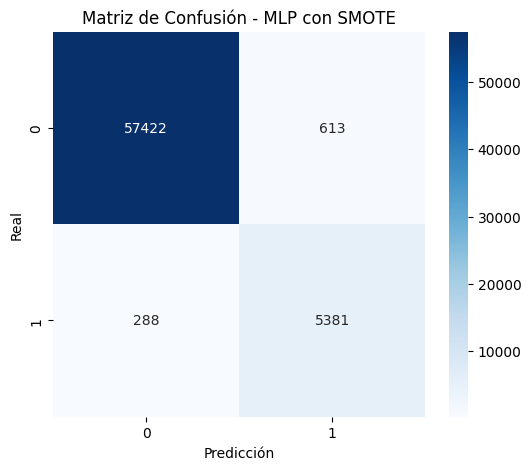

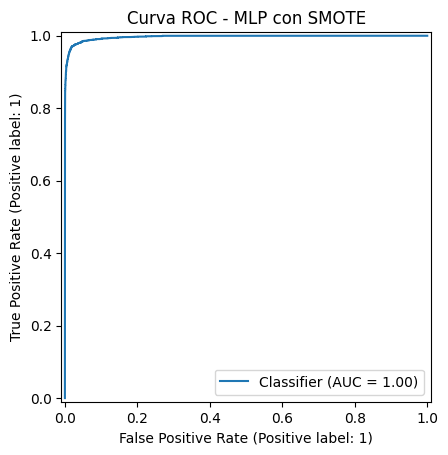

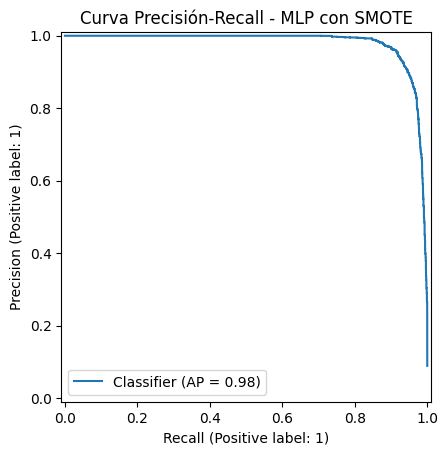

In [32]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========================
# 1. DEFINICIÓN DEL MODELO
# ========================

def build_model():
    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ===============================
# 2. PIPELINE: SMOTE + ESCALADO + MLP
# ===============================

clf = KerasClassifier(
    model=build_model,
    epochs=20,
    batch_size=256,
    verbose=0
)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('mlp', clf)
])

# ============================
# 3. VALIDACIÓN CRUZADA (CV 5)
# ============================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

print(f"\n✅ F1-score promedio (CV con SMOTE): {scores.mean():.4f} ± {scores.std():.4f}")

# ===========================
# 4. ENTRENAMIENTO FINAL PARA EVALUACIÓN
# ===========================

# Dividir conjunto de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Rebalancear el conjunto de entrenamiento
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Red neuronal final
final_model = build_model()
final_model.fit(
    X_train_scaled, y_train_smote,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# =============================
# 5. PREDICCIÓN Y MÉTRICAS FINALES
# =============================

# Probabilidades y predicción binaria
y_proba = final_model.predict(X_test_scaled).flatten()
y_pred = (y_proba >= 0.5).astype(int)

# Informe de clasificación
print("\n📊 Informe de clasificación sobre conjunto de test real (con SMOTE):\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - MLP con SMOTE")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - MLP con SMOTE")
plt.show()

# Curva Precisión-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Curva Precisión-Recall - MLP con SMOTE")
plt.show()


In [34]:
# Guardar en formato TensorFlow (.keras)
model.save("mlp_model.keras")